In [1]:
import pandas as pd 
import numpy as np
import re
import collections
import matplotlib.pyplot as plt
from pathlib import Path

# Packages for data preparation
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# Packages for modeling
from keras import models
from keras import layers
from keras import regularizers

Using TensorFlow backend.


In [2]:
glove_file = 'glove.42B.300d.txt'
emb_dict = {}
glove = open(glove_file, 'r')

for line in glove:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:], dtype='float32')
    emb_dict[word] = vector
glove.close()

In [3]:
airline_words = ['humanities', 'provides', 'effects', 'service']
for w in airline_words:
    if w in emb_dict.keys():
        print('Found the word {} in the dictionary'.format(w))
    else:
        print('{} not found in the dictionary'.format(w))
        

Found the word humanities in the dictionary
Found the word provides in the dictionary
Found the word effects in the dictionary
Found the word service in the dictionary


In [4]:
NB_WORDS = 10000  # Parameter indicating the number of words we'll put in the dictionary
VAL_SIZE = 1000  # Size of the validation set
NB_START_EPOCHS = 10  # Number of epochs we usually start to train with
BATCH_SIZE = 512  # Size of the batches used in the mini-batch gradient descent
MAX_LEN = 24  # Maximum number of words in a sequence
GLOVE_DIM = 300  # Number of dimensions of the GloVe word embeddings

In [21]:
X_train = pd.read_csv('PRE_afterPPT.csv', header=None, index_col=False)
X_train.columns = ["text", 'CAI State Score', 'Post Presentation Score', 'STAI State Score', 'State Anxiety Enthusiasm Score']
X_train = X_train.drop([0])
X_train.head()

,text,CAI State Score,Post Presentation Score,STAI State Score,State Anxiety Enthusiasm Score
1,The article talk about the in the Mexican Revo...,52,12,51,70
2,Hello all today I will be talking about the on...,52,14,56,62
3,And today I'm going to be talking about Today ...,59,9,49,66
4,With the recent holiday season coming up it's\...,59,14,47,68
5,I'm going to talk to you guys about\nFacebook\...,42,16,28,47


In [23]:
X = X_train['text']
y = X_train['State Anxiety Enthusiasm Score']

## Converting words to numbers

In [24]:
tk = Tokenizer(num_words=NB_WORDS,
               filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
               lower=True,
               split=" ")

In [25]:
tk.fit_on_texts(X)
X_train_seq = tk.texts_to_sequences(X)

In [31]:
seq_lengths = X.apply(lambda x: len(x.split(' ')))
seq_lengths.describe()

count     12.000000
mean     493.166667
std      161.462539
min      157.000000
25%      409.250000
50%      517.500000
75%      628.000000
max      702.000000
Name: text, dtype: float64

In [32]:
X_train_seq_trunc = pad_sequences(X_train_seq, maxlen=MAX_LEN)

In [33]:
le = LabelEncoder()
y_train_le = le.fit_transform(y)
y_train_oh = to_categorical(y_train_le)

In [34]:
X_train_emb, X_valid_emb, y_train_emb, y_valid_emb = train_test_split(X_train_seq_trunc, y_train_oh, test_size=0.1, random_state=37)

In [35]:
emb_matrix = np.zeros((NB_WORDS, GLOVE_DIM))

for w, i in tk.word_index.items():
    # The word_index contains a token for all words of the training data so we need to limit that
    if i < NB_WORDS:
        vect = emb_dict.get(w)
        # Check if the word from the training data occurs in the GloVe word embeddings
        # Otherwise the vector is kept with only zeros
        if vect is not None:
            emb_matrix[i] = vect
    else:
        break

In [40]:
glove_model = models.Sequential()
glove_model.add(layers.Embedding(NB_WORDS, GLOVE_DIM, input_length=MAX_LEN))
glove_model.add(layers.Flatten())
glove_model.add(layers.Dense(9, activation='softmax'))
glove_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 24, 300)           3000000   
_________________________________________________________________
flatten_4 (Flatten)          (None, 7200)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 9)                 64809     
Total params: 3,064,809
Trainable params: 3,064,809
Non-trainable params: 0
_________________________________________________________________


In [41]:
glove_model.layers[0].set_weights([emb_matrix])
glove_model.layers[0].trainable = False

In [55]:
def deep_model(model, X_train, y_train):
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    
    history = model.fit(X_train, y_train, epochs=NB_START_EPOCHS, batch_size=BATCH_SIZE)
    return history

In [49]:
def eval_metric(history, metric_name):
    metric = history.history[metric_name]
    val_metric = history.history[metric_name]

    e = range(1, NB_START_EPOCHS + 1)

    plt.plot(e, metric, 'bo', label='Train ' + metric_name)
    plt.plot(e, val_metric, 'b', label='Validation ' + metric_name)
    plt.legend()
    plt.show()

In [47]:
def test_model(model, X_train, y_train, X_test, y_test, epoch_stop):
    model.fit(X_train
              , y_train
              , epochs=epoch_stop
              , batch_size=BATCH_SIZE
              , verbose=0)
    results = model.evaluate(X_test, y_test)
    
    return results

In [54]:
glove_history = deep_model(glove_model, X_train_emb, y_train_emb)

Epoch 1/10
10/10 [==============================] - 0s 5ms/step - loss: 7.6315e-05 - accuracy: 1.0000
Epoch 2/10
10/10 [==============================] - 0s 393us/step - loss: 1.5974e-06 - accuracy: 1.0000
Epoch 3/10
10/10 [==============================] - 0s 196us/step - loss: 1.3828e-06 - accuracy: 1.0000
Epoch 4/10
10/10 [==============================] - 0s 318us/step - loss: 1.2517e-06 - accuracy: 1.0000
Epoch 5/10
10/10 [==============================] - 0s 358us/step - loss: 1.1802e-06 - accuracy: 1.0000
Epoch 6/10
10/10 [==============================] - 0s 252us/step - loss: 1.0729e-06 - accuracy: 1.0000
Epoch 7/10
10/10 [==============================] - 0s 277us/step - loss: 9.8944e-07 - accuracy: 1.0000
Epoch 8/10
10/10 [==============================] - 0s 310us/step - loss: 9.2983e-07 - accuracy: 1.0000
Epoch 9/10
10/10 [==============================] - 0s 345us/step - loss: 8.4639e-07 - accuracy: 1.0000
Epoch 10/10
10/10 [==============================] - 0s 573us/step

In [45]:
glove_history.history

{'loss': [0.011686431244015694,
  0.0001588396553415805,
  0.00012625704403035343,
  0.00011460038513178006,
  0.00010667407332221046,
  0.0001001898999675177,
  9.463536844123155e-05,
  8.953372889664024e-05,
  8.488501771353185e-05,
  8.047467417782173e-05],
 'accuracy': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]}

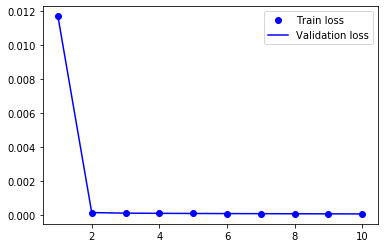

In [50]:
eval_metric(glove_history, 'loss')